In [1]:
# !pip install SimpleITK
# !pip install scikit-image
# !pip install scikit-image
!pip install antspyx

                                              0.0/248.7 MB ? eta -:--:--
                                              0.0/248.7 MB ? eta -:--:--
                                            0.1/248.7 MB 656.4 kB/s eta 0:06:19
                                              0.3/248.7 MB 1.9 MB/s eta 0:02:11
                                              0.9/248.7 MB 4.9 MB/s eta 0:00:51
                                             2.4/248.7 MB 10.1 MB/s eta 0:00:25
                                             3.0/248.7 MB 12.8 MB/s eta 0:00:20
                                             3.9/248.7 MB 11.8 MB/s eta 0:00:21
                                             4.3/248.7 MB 11.8 MB/s eta 0:00:21
                                             5.5/248.7 MB 13.1 MB/s eta 0:00:19
                                             5.7/248.7 MB 13.6 MB/s eta 0:00:18
                                             6.1/248.7 MB 11.8 MB/s eta 0:00:21
     -                                       7.5/248.7

  error: subprocess-exited-with-error
  
  × Building wheel for antspyx (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [912 lines of output]
      running bdist_wheel
      running build
      running build_py
      running build_ext
      Configuring ITK
      No local ITK installation found... Building ITK now...
      Cloning into 'itksource'...
      Updating files:  11% (1948/16558)
      Updating files:  12% (1987/16558)
      Updating files:  13% (2153/16558)
      Updating files:  14% (2319/16558)
      Updating files:  15% (2484/16558)
      Updating files:  16% (2650/16558)
      Updating files:  17% (2815/16558)
      Updating files:  18% (2981/16558)
      Updating files:  19% (3147/16558)
      Updating files:  20% (3312/16558)
      Updating files:  21% (3478/16558)
      Updating files:  22% (3643/16558)
      Updating files:  23% (3809/16558)
      Updating files:  24% (3974/16558)
      Updating files:  24% (3999/16558)
      Updating files:  25% (41

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
from skimage import transform

reference_image = nib.load('../images/FLAIR.nii.gz').get_fdata()
switch_image = nib.load('../images/T1.nii.gz').get_fdata()
seg_image = nib.load("../images/segmentation.nii.gz").get_fdata()
imagen_movil = nib.load('../images/T1.nii.gz')
imagen_estatica = nib.load('../images/FLAIR.nii.gz')

In [3]:
# plt.imshow(reference_image[:,:,25])
# print("Fixed image : ", reference_image.shape)
# print("Moving image : ", switch_image.shape)

In [4]:
def kmeans_segmentation(image, k, tol, max_iter, output_folder):
    # Inicializamos los centroides con valores entre el mínimo y el máximo valor de la imagen
    centroids = np.linspace(np.min(image), np.max(image), k)

    for i in range(max_iter):
        # Calculamos la distancia entre los valores de la imagen y los centroides
        distances = np.abs(image - centroids[..., None, None, None])

        # Asignamos cada pixel a su centroide más cercano
        segmentation = np.argmin(distances, axis=0)

        # Calculamos los nuevos centroides como la media de los valores asignados a cada cluster
        new_centroids = np.array([np.mean(image[segmentation == j]) for j in range(k)])

        # Comprobamos si la diferencia entre los nuevos y los antiguos centroides es menor que la tolerancia
        if np.all(np.abs(new_centroids - centroids) < tol):
            break

        # Asignamos los nuevos centroides
        centroids = new_centroids

    # Convertir la imagen segmentada a tipo de datos float32
    segmentation = segmentation.astype(np.float32)

    # Guardar la imagen segmentada en formato NIfTI
    image_segmented = nib.Nifti1Image(segmentation, affine=np.eye(4))
    output_path = f"{output_folder}/segmentation.nii.gz"
    nib.save(image_segmented, output_path)
    print(f"Imagen segmentada guardada en {output_path}")

    return segmentation

In [5]:
def registro_rigido(imagen_movil, imagen_referencia, output_folder="../images/"):
    # Cargar las imágenes usando SimpleITK
    imagen_movil_sitk = sitk.ReadImage(imagen_movil)
    imagen_referencia_sitk = sitk.ReadImage(imagen_referencia)

    # Convertir la imagen móvil a tipo de datos float32
    imagen_movil_sitk = sitk.Cast(imagen_movil_sitk, sitk.sitkFloat32)

    # Crear el objeto de registro rígido
    registro_rigido = sitk.ImageRegistrationMethod()

    # Configurar los parámetros del registro rígido
    registro_rigido.SetMetricAsMeanSquares()
    registro_rigido.SetOptimizerAsRegularStepGradientDescent(learningRate=0.1, minStep=1e-4, numberOfIterations=100)
    registro_rigido.SetInitialTransform(sitk.TranslationTransform(imagen_movil_sitk.GetDimension()))

    # Realizar el registro rígido
    transformada_resultado = registro_rigido.Execute(imagen_referencia_sitk, imagen_movil_sitk)

    # Aplicar la transformación alineada a la imagen móvil completa
    imagen_movil_registrada = sitk.Resample(imagen_movil_sitk, imagen_referencia_sitk, transformada_resultado, sitk.sitkLinear, 0.0, sitk.sitkFloat64)

    # Obtener la matriz tridimensional de la imagen móvil registrada y reordenar las dimensiones
    matriz_registrada = sitk.GetArrayFromImage(imagen_movil_registrada)
    matriz_registrada = np.transpose(matriz_registrada, (2, 1, 0))

    # Guardar la imagen registrada en formato NIfTI
    output_path = os.path.join(output_folder, "registration.nii.gz")
    image_segmented = nib.Nifti1Image(matriz_registrada, affine=np.eye(4))
    nib.save(image_segmented, output_path)
    print(f"Imagen segmentada guardada en {output_path}")

    return matriz_registrada


In [6]:
segmentation = kmeans_segmentation(switch_image,10,1,10, "../images/")

Imagen segmentada guardada en ../images//segmentation.nii.gz


In [7]:
registro_rigido_nifit = nib.load('../images/registration.nii.gz').get_fdata()

In [8]:
segmentatedIMG = nib.load('../images/segmentation.nii.gz').get_fdata()

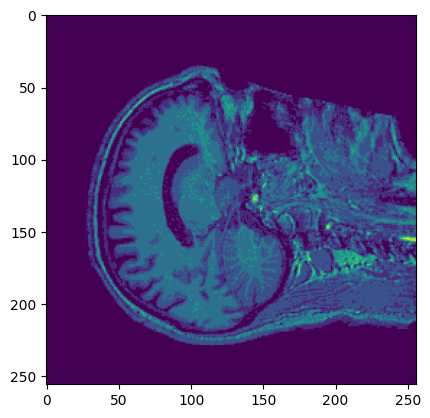

In [9]:
plt.imshow(segmentation[:,:,80])

Imagen segmentada guardada en ../images/registration.nii.gz


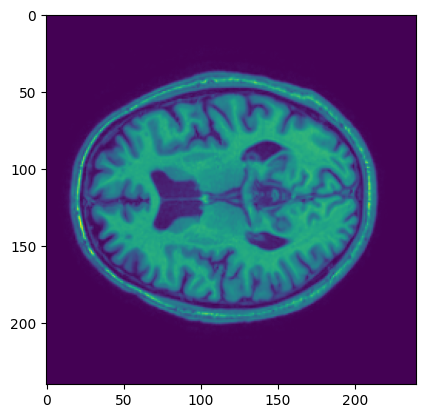

In [10]:
image_registro_rigido = registro_rigido(imagen_movil='../images/T1.nii.gz', imagen_referencia='../images/FLAIR.nii.gz')
plt.imshow(image_registro_rigido[:,:,22])
plt.show()

Text(0.5, 1.0, 'Registered')

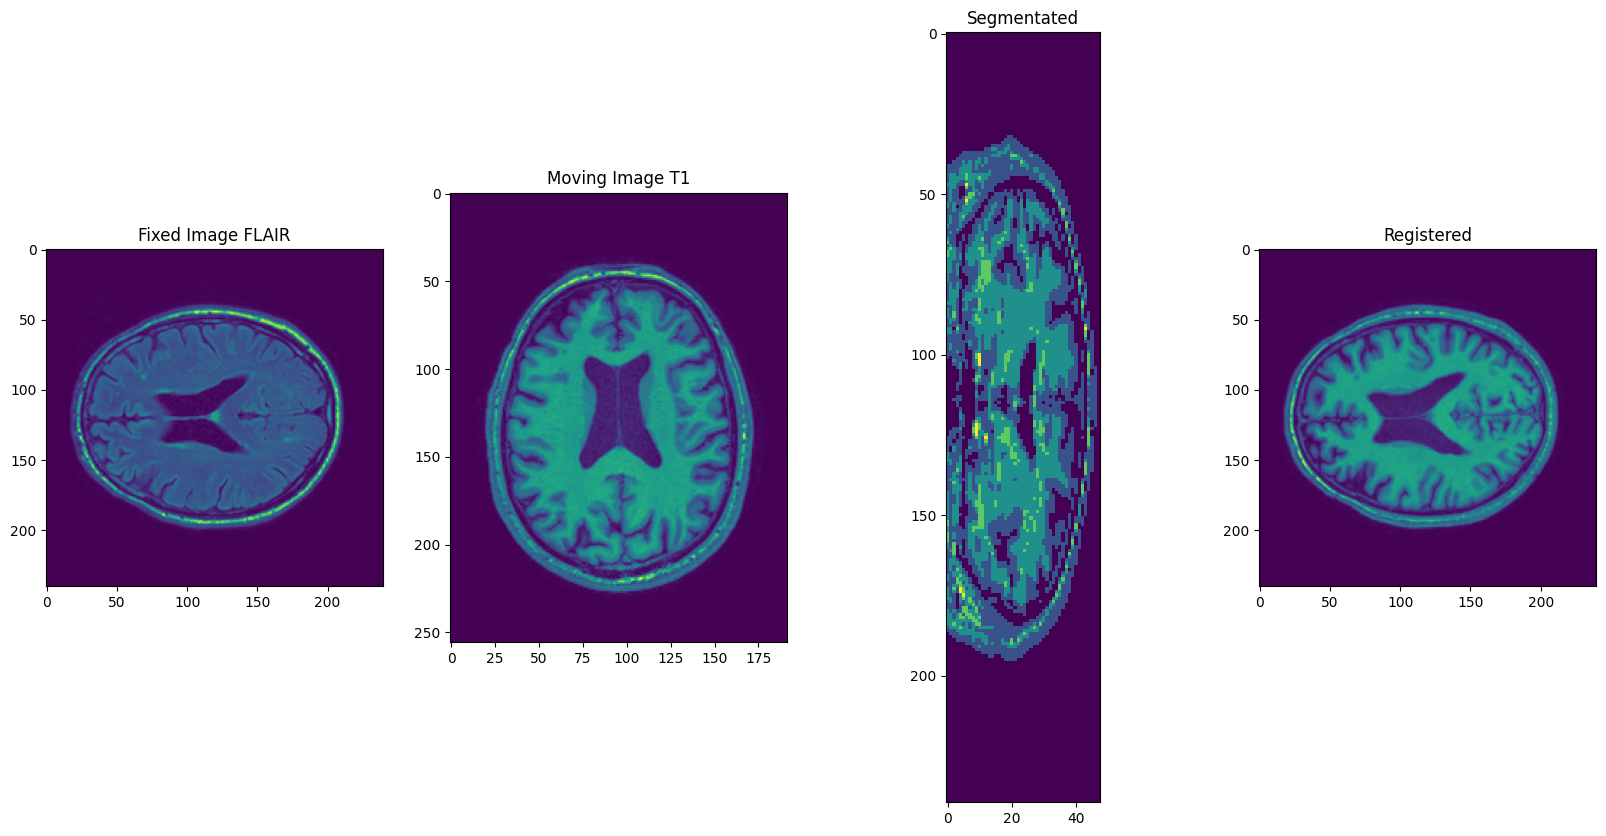

In [11]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
ax1.imshow(reference_image[:, :, 25])
ax1.set_title('Fixed Image FLAIR')
ax2.imshow(switch_image[:, 90, :])
ax2.set_title('Moving Image T1')
ax3.imshow(seg_image[:, 90, :])
ax3.set_title('Segmentated')
ax4.imshow(image_registro_rigido[:, :, 25])
ax4.set_title('Registered')


In [12]:
print("Fixed image : ", reference_image.shape)
print("Moving image : ", switch_image.shape)
print("Registered image : ", image_registro_rigido.shape)


Fixed image :  (240, 240, 48)
Moving image :  (256, 256, 192)
Registered image :  (240, 240, 48)


Imagen segmentada guardada en ../images//segmentation.nii.gz


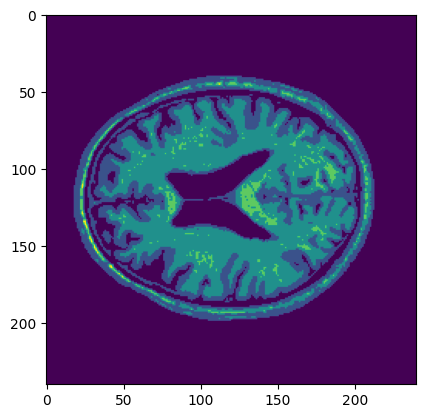

In [13]:
segmentation2 = kmeans_segmentation(image_registro_rigido,5,1,10, "../images/")
plt.imshow(segmentation2[:,:,25])
plt.show()

In [14]:
def calcular_volumen(imagen_nifti):
    # Cargar la imagen NIfTI
    imagen = nib.load(imagen_nifti)

    # Obtener los datos de la imagen
    datos = imagen.get_fdata()

    # Calcular el tamaño de voxel en cada dimensión
    voxel_sizes = imagen.header.get_zooms()

    # Calcular el volumen multiplicando el tamaño de voxel por el número de voxels
    volumen = (voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2]) * datos.size

    return volumen

In [15]:
vol = calcular_volumen('../images/segmentation.nii.gz')
print(vol)

2764800.0
